In [1]:
%load_ext autoreload
%autoreload 2
import sys
import torch
import copy
from torch import nn
from torch.utils import data
sys.path.append('..')
# sys.path.append('/system/user/beck/pwbeck/projects/regularization/ml_utilities')
from omegaconf import OmegaConf, DictConfig
from ml_utilities.torch_models import get_model_class
from ml_utilities.torch_utils import gradients_to_vector
from erank.data.datasetgenerator import DatasetGenerator
from erank.gradients import GradientCalculator
import matplotlib.pyplot as plt
import math
gpu_id = 3

## Setup

In [2]:
model_cfg = """
model:
  name: cnn2d
  out_channels: 64
  out_units: 10
  model_kwargs:
    image_size: 28
    in_channels: 1
    act_fn: relu
    layer_configs:
      - out_channels: ${model.out_channels}
        kernel_size: 3
        batch_norm: true
        stride: 1
        padding: 0
        max_pool_kernel_size: 2
      - out_channels: ${model.out_channels}
        kernel_size: 3
        batch_norm: true
        stride: 1
        padding: 0
        max_pool_kernel_size: 2
      - out_channels: ${model.out_channels}
        kernel_size: 3
        batch_norm: true
        stride: 1
        padding: 0
      - out_channels: ${model.out_channels}
        kernel_size: 3
        batch_norm: true
        stride: 1
        padding: 0
    linear_output_units:
      - ${model.out_units}
"""
model_cfg = OmegaConf.create(model_cfg)
cfg = f"""
dataset_generator_kwargs:
  dataset: rotatedvision
  dataset_kwargs:
    data_root_path: /system/user/beck/pwbeck/data #/home/max/phd/data 
    dataset: mnist
    rotation_angle: 0.0
  dataset_split:
    train_val_split: 0.8

run_path: /system/user/beck/pwbeck/projects/regularization/erank/outputs/mnist-11.4.0-conv4--221015_122409
model_idx: 20
default_loss: crossentropy
device: {gpu_id}
"""
cfg = OmegaConf.create(cfg)

In [3]:
gradient_calculator = GradientCalculator(**cfg)

## Playground

In [4]:
gradients = gradient_calculator.compute_gradients(batch_size=128)

 27%|██▋       | 101/375 [00:09<00:24, 11.01it/s]


KeyboardInterrupt: 

In [6]:
gs = torch.stack(gradients)

In [7]:
mean_grad = gs.mean(dim=0)
mean_abs_grad = mean_grad.abs()
mean_abs_grad.max(), mean_abs_grad.mean(), mean_abs_grad.median(), mean_abs_grad.std()

(tensor(0.0980, device='cuda:0'),
 tensor(0.0016, device='cuda:0'),
 tensor(0.0010, device='cuda:0'),
 tensor(0.0022, device='cuda:0'))

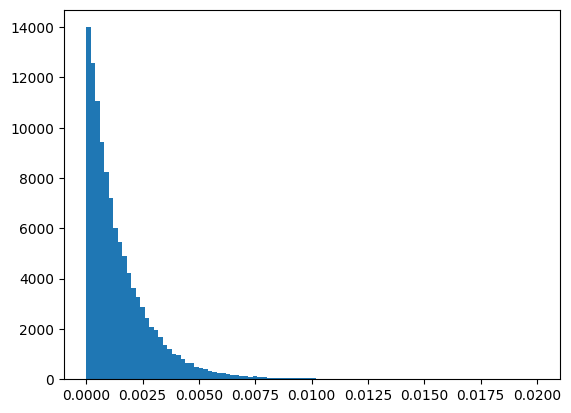

In [9]:
x = plt.hist(mean_abs_grad.cpu().numpy(), range=(0, 0.02), bins=100)

In [10]:
std = mean_grad.std().item()
r = 3

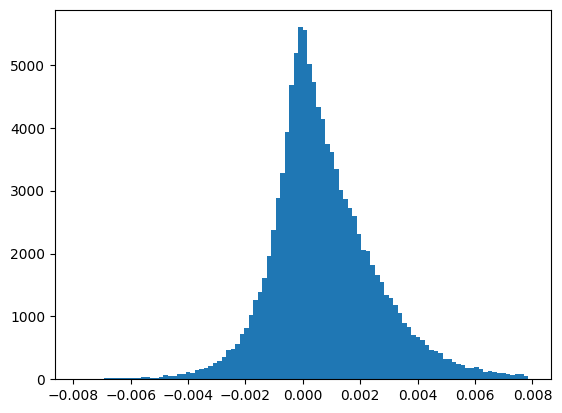

In [11]:
f = plt.hist(mean_grad.cpu().numpy(), bins=100, range=(-r*std, r*std))

In [12]:
med_vals, med_idxs = gs.median(dim=0)

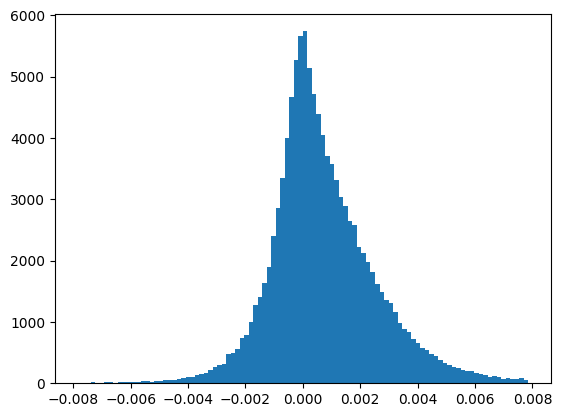

In [13]:
f = plt.hist(med_vals.cpu().numpy(), bins=100, range=(-r*std, r*std))


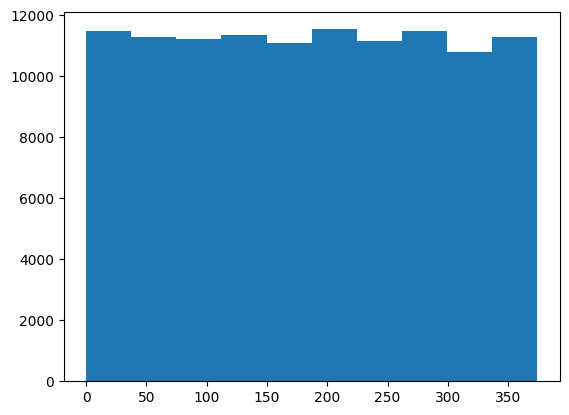

In [14]:
f = plt.hist(med_idxs.cpu().numpy())

## Magnitude pruning

In [30]:

from typing import Tuple

def magnitude_pruning_threshold(vec: torch.Tensor, frac_entries_to_prune: float) -> float:
    assert 0. <= frac_entries_to_prune <= 1.
    assert vec.ndim == 1
    vec_abs = vec.abs()
    vec_abs_sorted, _ = vec_abs.sort()
    n_elements_to_prune = math.floor(len(vec) * frac_entries_to_prune)
    threshold = vec_abs_sorted[n_elements_to_prune].item()
    return threshold

def magnitude_prune_vector(vec: torch.Tensor, frac_entries_to_prune: float) -> Tuple[torch.Tensor, torch.Tensor, float]:
    threshold = magnitude_pruning_threshold(vec, frac_entries_to_prune)
    pruning_mask_positive = vec.abs() > threshold
    pruned_vec = vec.masked_fill(pruning_mask_positive.logical_not(), 0.0)
    return pruned_vec, pruning_mask_positive, threshold

In [31]:
v = torch.linspace(0,10,10)
v_p, m, t = magnitude_prune_vector(v, 0.2)

In [32]:
v_p, m, t

(tensor([ 0.0000,  0.0000,  0.0000,  3.3333,  4.4444,  5.5556,  6.6667,  7.7778,
          8.8889, 10.0000]),
 tensor([False, False, False,  True,  True,  True,  True,  True,  True,  True]),
 2.222222328186035)

In [33]:
m.logical_not().float().sum()

tensor(3.)

In [37]:
from typing import Tuple

# now vectorized implementation


def magnitude_pruning_thresholds(vecs: torch.Tensor, frac_entries_to_prune: float, vec_dim: int = 1) -> torch.Tensor:
    assert 0. <= frac_entries_to_prune <= 1.
    assert vecs.ndim == 2
    vecs_abs = vecs.abs()
    # sort entries in the vector 
    vec_abs_sorted, _ = vecs_abs.sort(dim=vec_dim, descending=False)
    n_elements_to_prune = math.floor(vecs.shape[vec_dim] * frac_entries_to_prune)
    # thresholds are at the index, given by the fraction to prune
    thresholds = vec_abs_sorted.select(dim=vec_dim, index=n_elements_to_prune)
    thresholds.unsqueeze_(vec_dim)
    return thresholds


def magnitude_prune_vectors(vecs: torch.Tensor,
                            frac_entries_to_prune: float, vec_dim: int = 0) -> Tuple[torch.Tensor, torch.Tensor, float]:
    if vecs.ndim == 1:
        vecs = vecs.unsqueeze(0)
    thresholds = magnitude_pruning_thresholds(vecs, frac_entries_to_prune)
    pruning_mask_positive = vecs.abs() > thresholds
    pruned_vec = vecs.masked_fill(pruning_mask_positive.logical_not(), 0.0)
    return pruned_vec, pruning_mask_positive, thresholds

In [38]:
vs = v.repeat((3,1))
vs

tensor([[ 0.0000,  1.1111,  2.2222,  3.3333,  4.4444,  5.5556,  6.6667,  7.7778,
          8.8889, 10.0000],
        [ 0.0000,  1.1111,  2.2222,  3.3333,  4.4444,  5.5556,  6.6667,  7.7778,
          8.8889, 10.0000],
        [ 0.0000,  1.1111,  2.2222,  3.3333,  4.4444,  5.5556,  6.6667,  7.7778,
          8.8889, 10.0000]])

In [39]:
v_p, m, t = magnitude_prune_vectors(vs, 0.2)

In [40]:
v_p, m, t

(tensor([[ 0.0000,  0.0000,  0.0000,  3.3333,  4.4444,  5.5556,  6.6667,  7.7778,
           8.8889, 10.0000],
         [ 0.0000,  0.0000,  0.0000,  3.3333,  4.4444,  5.5556,  6.6667,  7.7778,
           8.8889, 10.0000],
         [ 0.0000,  0.0000,  0.0000,  3.3333,  4.4444,  5.5556,  6.6667,  7.7778,
           8.8889, 10.0000]]),
 tensor([[False, False, False,  True,  True,  True,  True,  True,  True,  True],
         [False, False, False,  True,  True,  True,  True,  True,  True,  True],
         [False, False, False,  True,  True,  True,  True,  True,  True,  True]]),
 tensor([[2.2222],
         [2.2222],
         [2.2222]]))

In [41]:
v_p, m, t = magnitude_prune_vectors(v, 0.2)

AssertionError: 